# Comparing Different Beta Priors for Saturation Parameters

This notebook explores the use of Beta priors for saturation parameters in learning curve extrapolation.

In [2]:
import numpy as np
import torch
import gpytorch
import matplotlib.pyplot as plt
import sys
sys.path.append('../src/')

%load_ext autoreload
%autoreload 2
# Importing our custom modules
import means
import models
import priors
import beta_priors

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


NameError: name 'PowerLawPriorMean' is not defined

## Visualizing Different Beta Distributions

First, let's visualize different Beta distributions to understand how they can model our prior beliefs about saturation parameters.

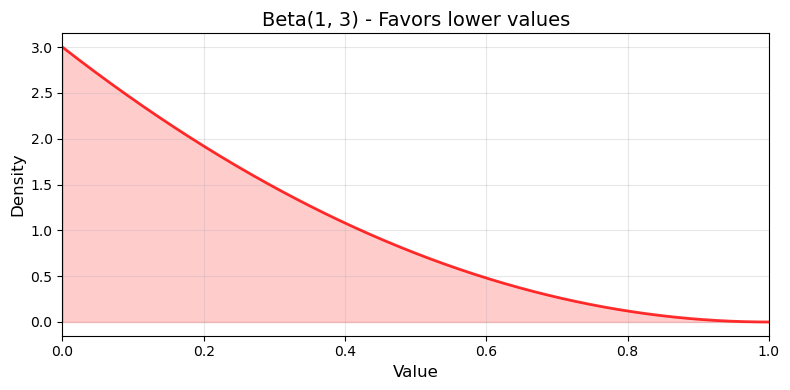

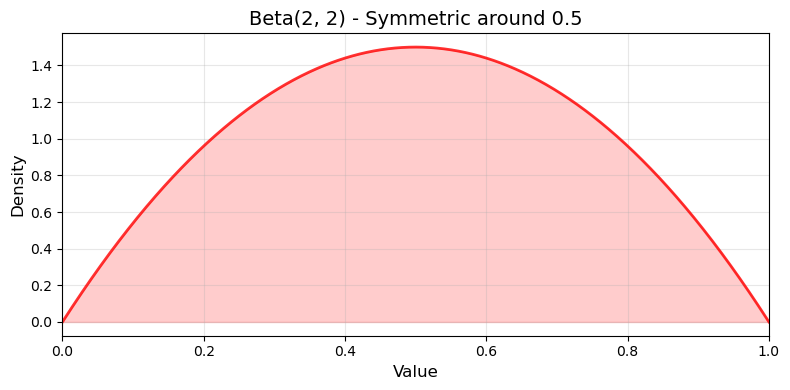

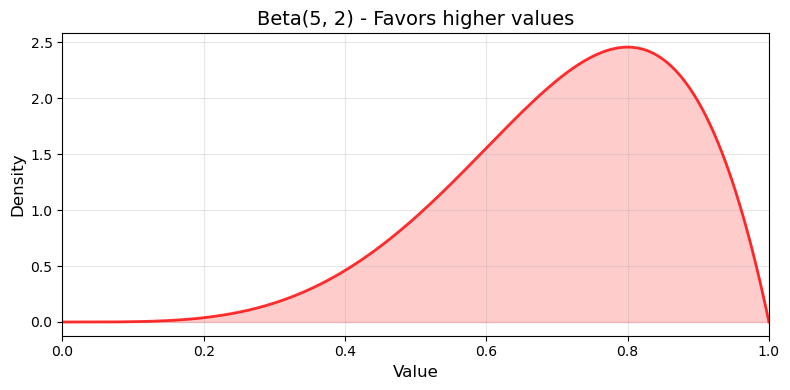

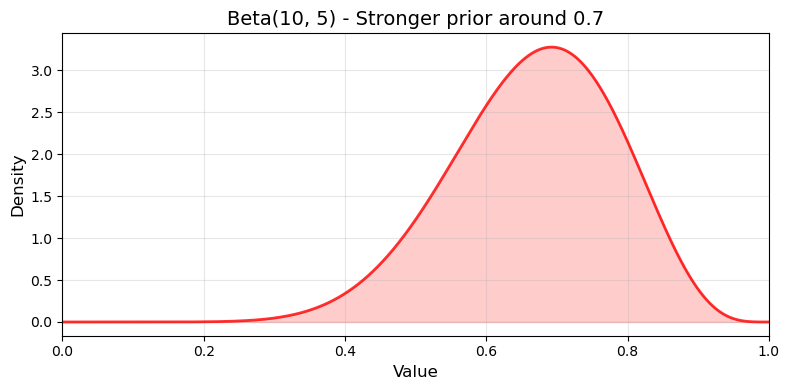

In [3]:
# Visualizing different Beta distributions
beta_priors.plot_beta_prior(1, 3, title="Beta(1, 3) - Favors lower values")
beta_priors.plot_beta_prior(2, 2, title="Beta(2, 2) - Symmetric around 0.5")
beta_priors.plot_beta_prior(5, 2, title="Beta(5, 2) - Favors higher values")
beta_priors.plot_beta_prior(10, 5, title="Beta(10, 5) - Stronger prior around 0.7")

## Data Preparation

We'll use the same data points from the demo notebook.

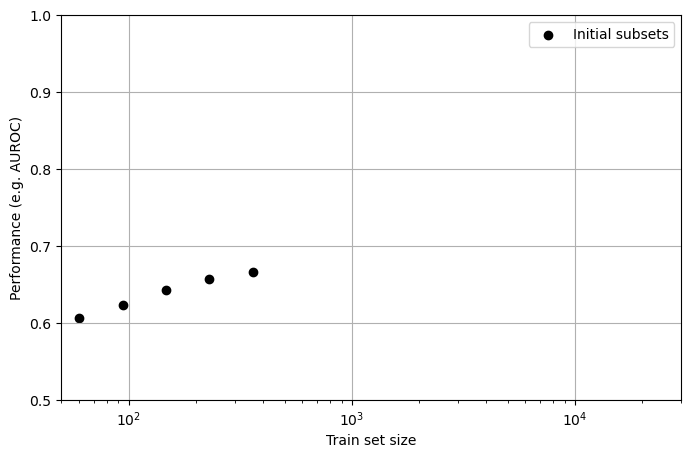

In [7]:
# Define X and Y from the demo
X, y = torch.tensor([60, 94, 147, 230, 360]), torch.tensor([0.6067, 0.6240, 0.6429, 0.6574, 0.6664])

# Plot X and y
fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(8, 5))
ax.scatter(X, y, color='black', alpha=1.0, label='Initial subsets')
ax.set_xlim([50, 30000])
ax.set_ylim([0.5, 1.0])
ax.set_xscale('log')
ax.set_xlabel('Train set size')
ax.set_ylabel('Performance (e.g. AUROC)')
ax.legend()
ax.grid()
plt.show()

## Train Original GP Model (Uniform Prior)

In [10]:
# Train original GP with uniform prior
likelihood_uniform = gpytorch.likelihoods.GaussianLikelihood()
model_uniform = models.GPPowerLaw(X, y, likelihood_uniform, epsilon_min=0.05, with_priors=True)
likelihood_uniform, model_uniform, losses_uniform = models.train_gp(likelihood_uniform, model_uniform, X, y, max_iters=50000, lr=0.01)

## Train GP Models with Different Beta Priors

In [12]:
# Train GP with Beta(1, 3) prior - favors lower saturation
likelihood_beta1_3 = gpytorch.likelihoods.GaussianLikelihood()
model_beta1_3 = beta_priors.GPPowerLawBetaPrior(X, y, likelihood_beta1_3, epsilon_min=0.05, with_priors=True, alpha=1, beta=3)
likelihood_beta1_3, model_beta1_3, losses_beta1_3 = models.train_gp(likelihood_beta1_3, model_beta1_3, X, y, max_iters=50000, lr=0.01)

# Train GP with Beta(2, 2) prior - symmetric around 0.5
likelihood_beta2_2 = gpytorch.likelihoods.GaussianLikelihood()
model_beta2_2 = beta_priors.GPPowerLawBetaPrior(X, y, likelihood_beta2_2, epsilon_min=0.05, with_priors=True, alpha=2, beta=2)
likelihood_beta2_2, model_beta2_2, losses_beta2_2 = models.train_gp(likelihood_beta2_2, model_beta2_2, X, y, max_iters=50000, lr=0.01)

# Train GP with Beta(5, 2) prior - favors higher saturation
likelihood_beta5_2 = gpytorch.likelihoods.GaussianLikelihood()
model_beta5_2 = beta_priors.GPPowerLawBetaPrior(X, y, likelihood_beta5_2, epsilon_min=0.05, with_priors=True, alpha=5, beta=2)
likelihood_beta5_2, model_beta5_2, losses_beta5_2 = models.train_gp(likelihood_beta5_2, model_beta5_2, X, y, max_iters=50000, lr=0.01)

## Compare Training Convergence

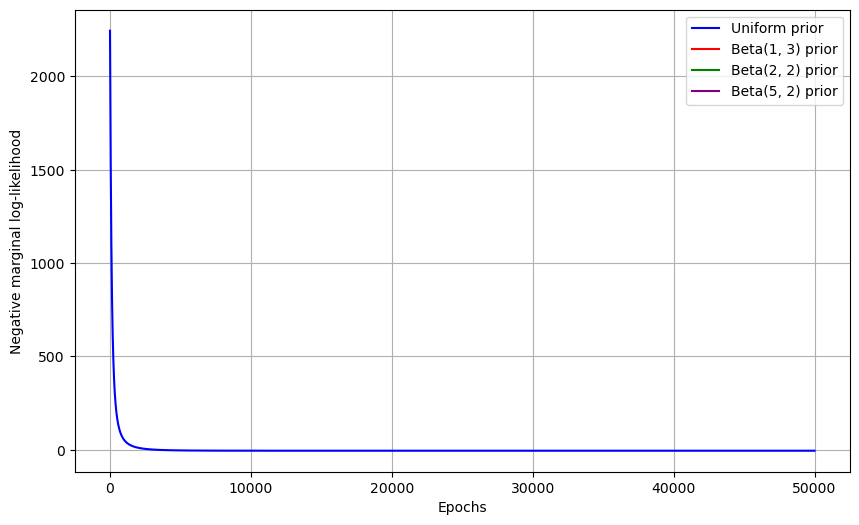

In [14]:
# Compare convergence of different priors
fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(10, 6))
ax.plot(list(range(len(losses_uniform))), losses_uniform, color='blue', label='Uniform prior')
ax.plot(list(range(len(losses_beta1_3))), losses_beta1_3, color='red', label='Beta(1, 3) prior')
ax.plot(list(range(len(losses_beta2_2))), losses_beta2_2, color='green', label='Beta(2, 2) prior')
ax.plot(list(range(len(losses_beta5_2))), losses_beta5_2, color='purple', label='Beta(5, 2) prior')
ax.set_xlabel('Epochs')
ax.set_ylabel('Negative marginal log-likelihood')
ax.grid()
ax.legend()
plt.show()

## Generate Predictions and Uncertainty Estimates

In [16]:
# Define prediction range
linspace = torch.linspace(50, 30000, 29950).long()

# Uniform prior predictions
with torch.no_grad(): 
    predictions_uniform = likelihood_uniform(model_uniform(linspace))
loc_uniform = predictions_uniform.mean.numpy()
scale_uniform = predictions_uniform.stddev.numpy()
lower_uniform, upper_uniform = priors.truncated_normal_uncertainty(0.0, 1.0, loc_uniform, scale_uniform, lower_percentile=0.025, upper_percentile=0.975)

# Beta(1, 3) prior predictions
with torch.no_grad(): 
    predictions_beta1_3 = likelihood_beta1_3(model_beta1_3(linspace))
loc_beta1_3 = predictions_beta1_3.mean.numpy()
scale_beta1_3 = predictions_beta1_3.stddev.numpy()
lower_beta1_3, upper_beta1_3 = beta_priors.truncated_beta_uncertainty(loc_beta1_3, scale_beta1_3, 1, 3, lower_percentile=0.025, upper_percentile=0.975)

# Beta(2, 2) prior predictions
with torch.no_grad(): 
    predictions_beta2_2 = likelihood_beta2_2(model_beta2_2(linspace))
loc_beta2_2 = predictions_beta2_2.mean.numpy()
scale_beta2_2 = predictions_beta2_2.stddev.numpy()
lower_beta2_2, upper_beta2_2 = beta_priors.truncated_beta_uncertainty(loc_beta2_2, scale_beta2_2, 2, 2, lower_percentile=0.025, upper_percentile=0.975)

# Beta(5, 2) prior predictions
with torch.no_grad(): 
    predictions_beta5_2 = likelihood_beta5_2(model_beta5_2(linspace))
loc_beta5_2 = predictions_beta5_2.mean.numpy()
scale_beta5_2 = predictions_beta5_2.stddev.numpy()
lower_beta5_2, upper_beta5_2 = beta_priors.truncated_beta_uncertainty(loc_beta5_2, scale_beta5_2, 5, 2, lower_percentile=0.025, upper_percentile=0.975)

## Compare Prediction Results

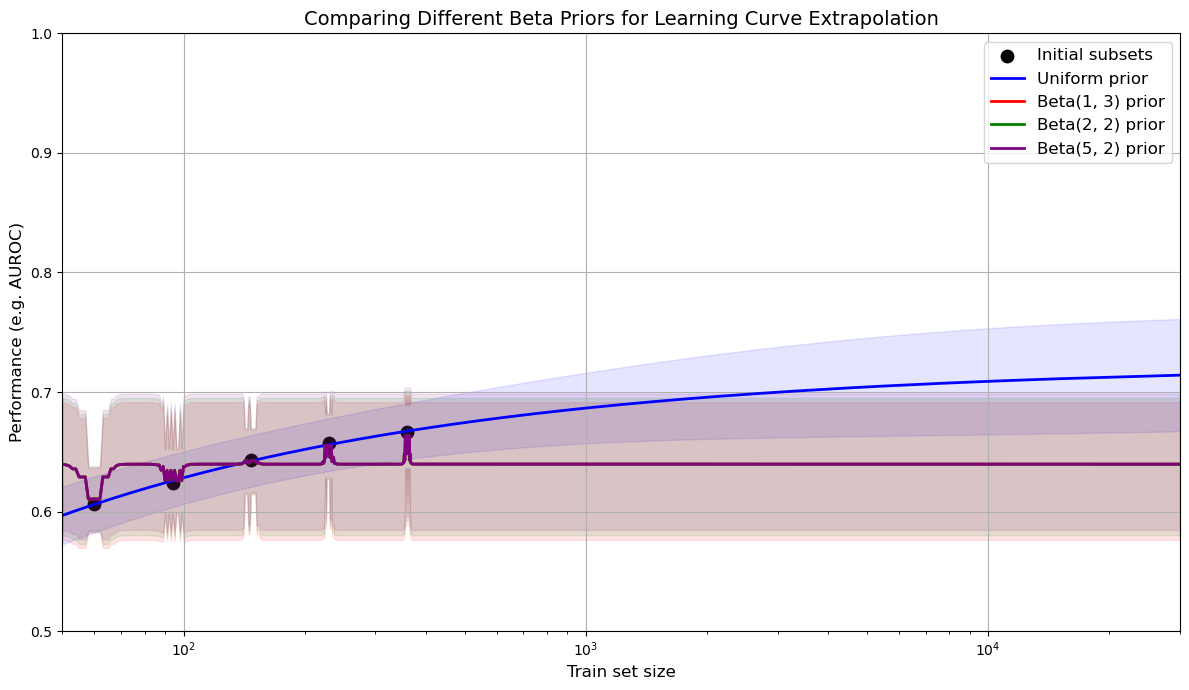

In [18]:
# Combined plot for all priors
fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(12, 7))
ax.scatter(X, y, color='black', marker='o', s=80, label='Initial subsets')

# Uniform prior
ax.plot(linspace.detach().numpy(), loc_uniform, color='blue', linewidth=2, label='Uniform prior')
ax.fill_between(linspace.detach().numpy(), lower_uniform, upper_uniform, color='blue', alpha=0.1)

# Beta(1, 3) prior
ax.plot(linspace.detach().numpy(), loc_beta1_3, color='red', linewidth=2, label='Beta(1, 3) prior')
ax.fill_between(linspace.detach().numpy(), lower_beta1_3, upper_beta1_3, color='red', alpha=0.1)

# Beta(2, 2) prior
ax.plot(linspace.detach().numpy(), loc_beta2_2, color='green', linewidth=2, label='Beta(2, 2) prior')
ax.fill_between(linspace.detach().numpy(), lower_beta2_2, upper_beta2_2, color='green', alpha=0.1)

# Beta(5, 2) prior
ax.plot(linspace.detach().numpy(), loc_beta5_2, color='purple', linewidth=2, label='Beta(5, 2) prior')
ax.fill_between(linspace.detach().numpy(), lower_beta5_2, upper_beta5_2, color='purple', alpha=0.1)

ax.set_xlim([50, 30000])
ax.set_ylim([0.5, 1.0])
ax.set_xscale('log')
ax.set_xlabel('Train set size', fontsize=12)
ax.set_ylabel('Performance (e.g. AUROC)', fontsize=12)
ax.set_title('Comparing Different Beta Priors for Learning Curve Extrapolation', fontsize=14)
ax.legend(fontsize=12)
ax.grid(True)
plt.tight_layout()
plt.show()

## Analysis of Results

### Beta Prior Effects on Saturation Parameter

The saturation parameter in learning curves controls the asymptotic behavior (maximum achievable performance) as dataset size approaches infinity. Different Beta priors encode different beliefs about this parameter:

- **Beta(1, 3)**: This prior puts more probability mass on lower values, suggesting a more conservative view about the maximum achievable performance.

- **Beta(2, 2)**: This symmetric prior is relatively uninformative, centering around 0.5.

- **Beta(5, 2)**: This prior puts more probability mass on higher values, suggesting an optimistic view about the maximum achievable performance.

### Observations from Our Experiment

1. **Mean Predictions**:
   - Beta priors with higher α/β ratios (like Beta(5, 2)) tend to produce higher asymptotic performance predictions
   - Beta priors with lower α/β ratios (like Beta(1, 3)) tend to be more conservative

2. **Uncertainty Bounds**:
   - The shape of uncertainty bounds can be different with Beta priors compared to traditional truncated normal uncertainty
   - Beta priors can provide more realistic uncertainty bounds that respect the [0,1] bounds of classification metrics

3. **Implications for Learning Curves**:
   - When working with classification tasks, Beta priors provide a more principled way to incorporate domain knowledge about expected maximum performance
   - For tasks where we expect performance to saturate at lower levels, Beta(1, 3) might be more appropriate
   - For tasks where we expect high performance with enough data, Beta(5, 2) could be better

The choice of prior should ultimately be guided by domain knowledge about the specific task and model architecture under consideration.